In [203]:
import os # Interacts with operating systems
from glob import glob # Return all file paths that match a specific pattern

from tqdm import tqdm # Shows progress bar
import cv2 # Computer Vision library
import numpy as np # Support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions
import pandas as pd # Support for data manipulation and analysis
import random
from itertools import groupby 

import plotly.express as px # Graphing library
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

import torch # Used for CNN in general
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn # CNN neural network

from catboost import CatBoostRegressor # CatBoost package 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb # LGBM package

from sklearn.preprocessing import StandardScaler # ANN package
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout



In [204]:
main_path = "C:/Users/skmoon/Desktop/open"
train_imgs = glob(main_path+"/train/*/*/*.png") + glob(main_path+"/train/*/*/*.jpg")
train_imgs = sorted(train_imgs)
test_imgs = glob(main_path+"/test/image/*.png") + glob(main_path+"/test/image/*.jpg")
test_imgs = sorted(test_imgs)
train_data = glob(main_path+"/train/*/meta/*.csv")
train_label = glob(main_path+"/train/*/*.csv")
test_data = glob(main_path+"/test/meta/*.csv")
preprocessing_train_imgs = "C:/Users/skmoon/Desktop/open/PREPROCESSING-TRAIN"
preprocessing_test_imgs = "C:/Users/skmoon/Desktop/open/PREPROCESSING-TEST"
if not os.path.exists(preprocessing_train_imgs):
    os.mkdir(preprocessing_train_imgs)
if not os.path.exists(preprocessing_test_imgs):
    os.mkdir(preprocessing_test_imgs)

In [205]:
def automatic_brightness_and_contrast(image, clip_hist_percent=0.025):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    
    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

In [135]:

def get_image_data(dir_in, dir_out):
    ratio_list = []

    for i in tqdm(dir_in):
        name = i.split("\\")[-1]
        img = cv2.imread(i, cv2.IMREAD_COLOR)
        img = cv2.resize(img,(615,462))
        brightscale, alpha, beta = automatic_brightness_and_contrast(img)
        imgcopy = brightscale.copy()
        hsvimage = cv2.cvtColor(brightscale, cv2.COLOR_BGR2HSV)
        lower = np.array([22,40,0])
        upper = np.array([85,255,245])
        mask = cv2.inRange(hsvimage, lower, upper)
        number_of_white_pix = np.sum(mask == 255)
        number_of_black_pix = np.sum(mask == 0)
        ratio = number_of_white_pix / (number_of_white_pix + number_of_black_pix)
        ratio_list.append(ratio)
        result = cv2.bitwise_and(imgcopy, imgcopy, mask=mask)
        cv2.imwrite(os.path.join(dir_out,name), result)
    
    return ratio_list

ratio_train = get_image_data(train_imgs, preprocessing_train_imgs)
ratio_test = get_image_data(test_imgs, preprocessing_test_imgs)

processed_train_imgs = glob(main_path+"/PREPROCESSING-TRAIN/*.png") + glob(main_path+"/PREPROCESSING-TRAIN/*.jpg")
processed_train_imgs = sorted(processed_train_imgs)

processed_test_imgs = glob(main_path+"/PREPROCESSING-TEST/*.png") + glob(main_path+"/PREPROCESSING-TEST/*.jpg")
processed_test_imgs = sorted(processed_test_imgs)

100%|██████████| 460/460 [01:31<00:00,  5.05it/s]


In [157]:
# Train data with mean unit

train_df = []
for i in tqdm(train_data):
    name = i.split("\\")[-1].split(".")[0]
    df = pd.read_csv(i)
    df = df.drop('시간', axis = 1)
    case = name.split("_")[0]
    label = pd.read_csv(f"C:/Users/skmoon/Desktop/open/train/{case}/label.csv")
    label_name = [i.split(".")[0] for i in label.img_name]
    label.img_name = label_name
    leaf_weight = label[label.img_name == name].leaf_weight.values[0]
    df["무게"] = leaf_weight
    # df["화이트 LED동작강도"] = df["화이트 LED동작강도"].fillna(method='bfill', limit=1)
    # df["화이트 LED동작강도"] = df["화이트 LED동작강도"].fillna(method='ffill', limit=1)
    # df["레드 LED동작강도"] = df["레드 LED동작강도"].fillna(method='bfill', limit=1)
    # df["레드 LED동작강도"] = df["레드 LED동작강도"].fillna(method='ffill', limit=1)
    # df["블루 LED동작강도"] = df["블루 LED동작강도"].fillna(method='bfill', limit=1)
    # df["블루 LED동작강도"] = df["블루 LED동작강도"].fillna(method='ffill', limit=1)
    df["최근분무량"] = df["최근분무량"].fillna(method='bfill', limit=1)
    df["최근분무량"] = df["최근분무량"].fillna(method='ffill', limit=1)
    df = df.interpolate()
    water = df['최근분무량'].round(2).tolist()
    if np.mean(water) > 1000:
        nums = [list(v) for k,v in groupby(water, key = lambda x: x != 0) if k != 0]
        if len(nums) == 2:
            cumulative = nums[0][-1] - nums[0][0] + nums[1][-1]
        else:
            cumulative = nums[0][-1] - nums[0][0]
            
    elif 1000 > np.mean(water) > 0:
        nums = [key for key, _group in groupby(water)]
        cumulative = sum(nums[1:])
    else:
        cumulative = 0
    # df = df.fillna(0)
    '''
    정량이 정해져 있음 bbfill, ffill (LED, 분무량)
    정량이 정해져 있지 않음 interpolate (그외)
    '''
    df = df.mean()
    df = df.to_frame().T
    df["이미지"] = name
    df['최근분무량'] = cumulative

    train_df.append(df)

train_df = pd.concat(train_df, ignore_index=True)
train_df['비율'] = ratio_train
train_df.head()

100%|██████████| 1592/1592 [00:37<00:00, 42.55it/s]


,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,...,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,무게,이미지,비율
0,22.236181,43.868542,77.740695,4.679291,487.226389,19.594792,0.0,200.720833,201.000000,0.139583,...,179.460356,18.854103,10.228598,145.944829,12.396061,21.119466,NaN,49.193,CASE01_01,0.099880
1,23.011319,44.573750,77.645972,4.537500,480.144444,20.855555,0.0,200.861111,200.861111,0.139583,...,179.471631,18.853965,13.709128,145.980283,12.391464,21.099885,NaN,59.764,CASE01_02,0.120072
2,22.931111,39.537708,77.514931,4.886111,489.068750,20.748611,0.0,200.651042,200.373264,0.139583,...,179.523570,18.854171,13.348331,146.015736,12.374227,21.133608,NaN,72.209,CASE01_03,0.141692
3,21.027986,58.497500,80.069930,3.908333,481.378472,18.195278,0.0,200.025000,200.163889,0.139583,...,179.495845,18.854174,7.520480,145.997472,12.370205,21.128169,NaN,85.737,CASE01_04,0.166315
4,21.874305,67.058819,81.349792,3.908333,490.568750,19.400486,0.0,200.861111,201.000000,0.139583,...,179.488241,18.854140,10.943552,145.971688,12.394912,21.121642,NaN,102.537,CASE01_05,0.191525


In [158]:
test_df = []
for i in tqdm(test_data):
    name = i.split("\\")[-1].split(".")[0]
    df = pd.read_csv(i)
    df = df.drop('시간', axis = 1)
    # df["화이트 LED동작강도"] = df["화이트 LED동작강도"].fillna(method='bfill', limit=1)
    # df["화이트 LED동작강도"] = df["화이트 LED동작강도"].fillna(method='ffill', limit=1)
    # df["레드 LED동작강도"] = df["레드 LED동작강도"].fillna(method='bfill', limit=1)
    # df["레드 LED동작강도"] = df["레드 LED동작강도"].fillna(method='ffill', limit=1)
    # df["블루 LED동작강도"] = df["블루 LED동작강도"].fillna(method='bfill', limit=1)
    # df["블루 LED동작강도"] = df["블루 LED동작강도"].fillna(method='ffill', limit=1)
    df["최근분무량"] = df["최근분무량"].fillna(method='bfill', limit=1)
    df["최근분무량"] = df["최근분무량"].fillna(method='ffill', limit=1)
    df = df.interpolate()
    water = df['최근분무량'].round(2).tolist()
    if np.mean(water) > 1000:
        nums = [list(v) for k,v in groupby(water, key = lambda x: x != 0) if k != 0]
        if len(nums) == 2:
            cumulative = nums[0][-1] - nums[0][0] + nums[1][-1]
        else:
            cumulative = nums[0][-1] - nums[0][0]
            
    elif 1000 > np.mean(water) > 0:
        nums = [key for key, _group in groupby(water)]
        cumulative = sum(nums[1:])
    else:
        cumulative = 0

    # df = df.fillna(0.0)

    df = df.mean()
    df = df.to_frame().T
    df["이미지"] = name
    df['최근분무량'] = cumulative

    test_df.append(df)

test_df = pd.concat(test_df, ignore_index=True)
test_df['비율'] = ratio_test  
test_df.head()

100%|██████████| 460/460 [00:08<00:00, 56.26it/s]


,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,이미지,비율
0,23.634861,22.564583,69.500486,34.499792,400.265278,0.000000,11509.28,47.195486,7.484722,13.488194,22.395829,6.198268,20.395829,0.000000,179.576697,146.045817,12.398359,21.132520,001,0.162299
1,27.170347,28.738472,63.881805,50.837708,505.823611,0.000000,4234.63,33.496181,9.506597,4.722222,23.396007,23.875345,22.396007,0.000000,126.724400,103.602930,15.725197,7.396273,002,0.526678
2,25.999340,25.541111,79.197812,65.936597,498.623611,1.778872,610.71,47.185417,7.487153,13.476736,20.291920,42.908664,17.416844,0.606961,179.532997,146.026479,12.390315,21.116202,003,0.011593
3,22.956944,22.361667,70.809792,45.378646,394.612500,0.592409,12271.85,47.183333,7.483333,13.479514,22.395793,2.911434,20.395793,0.000000,179.449739,145.950201,12.392039,21.107500,004,0.149154
4,23.014757,22.531736,73.886944,33.534167,418.561806,0.541303,13040.85,47.185417,7.466667,13.478125,22.395846,3.179260,20.395846,0.000000,179.480870,145.998546,12.365033,21.117290,005,0.168588


In [104]:
fig = go.Figure()

for path in train_label:
        df = pd.read_csv(path)
        weight = df['leaf_weight']
            
        fig.add_trace(go.Scatter(x=weight.index, y=weight,
            mode='lines',
            name=path.split("\\")[-2]))      

fig.update_layout(
    autosize=False,
    width=1500,
    height=1000,
    xaxis_title="Day",
    yaxis_title="Weight")

fig.show()

In [141]:
fig = px.scatter(train_df, x = '무게', y= '비율',
                 hover_name="이미지", trendline="ols")

fig.show()

In [160]:
# outliers = ['CASE23_01', 'CASE23_02', 'CASE23_03', 'CASE23_04', 'CASE23_05', 'CASE23_06', 'CASE23_07', 'CASE23_08', 'CASE23_09', 'CASE73_10'
# ,'CASE73_02', 'CASE73_14', 'CASE45_16', 'CASE45_17', 'CASE17_02', 'CASE59_01','CASE59_02','CASE59_03','CASE59_04','CASE59_05','CASE59_06',
# 'CASE59_07','CASE59_08','CASE59_09','CASE59_10','CASE59_11','CASE59_12','CASE59_13','CASE59_14','CASE59_15','CASE59_16','CASE59_17','CASE59_18',
# 'CASE59_19','CASE59_20','CASE59_21','CASE59_22','CASE59_23','CASE59_24','CASE59_25','CASE59_26','CASE59_27','CASE59_28','CASE59_29','CASE59_30',
# 'CASE59_31','CASE59_32', 'CASE59_33', 'CASE05_21','CASE05_22','CASE05_23', 'CASE09_08', 'CASE16_03', 'CASE31_06', 'CASE31_07', 'CASE07_07',
# 'CASE07_08','CASE72_06']

CNNoutliers = ['CASE05_21','CASE05_22','CASE05_23', 'CASE07_07', 'CASE07_08', 'CASE16_03', 'CASE23_01', 'CASE23_02', 
'CASE23_03', 'CASE23_04', 'CASE23_05', 'CASE23_06', 'CASE23_07', 'CASE23_08', 'CASE23_09', 'CASE45_16', 'CASE45_17',
'CASE72_06',  'CASE73_10', 'CASE59_01','CASE59_02','CASE59_03','CASE59_04','CASE59_05','CASE59_06',
'CASE59_07','CASE59_08','CASE59_09','CASE59_10','CASE59_11','CASE59_12','CASE59_13','CASE59_14','CASE59_15','CASE59_16','CASE59_17','CASE59_18',
'CASE59_19','CASE59_20','CASE59_21','CASE59_22','CASE59_23','CASE59_24','CASE59_25','CASE59_26','CASE59_27','CASE59_28','CASE59_29','CASE59_30',
'CASE59_31','CASE59_32', 'CASE59_33']

train_df = train_df[~train_df['이미지'].isin(CNNoutliers)]
removed_train_imgs = [ x for x in processed_train_imgs if x.split(".")[0].split("\\")[1] not in CNNoutliers]



In [107]:
corr = train_df.corr()

corr.style.background_gradient(cmap='coolwarm')

,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,무게,비율
내부온도관측치,1.000000,0.912871,0.806709,0.623661,0.906281,0.201779,0.038175,0.522684,0.081098,0.053742,0.947803,0.451319,0.949452,0.026437,0.575486,0.651616,0.153055,0.059358,0.047916,-0.006545
외부온도관측치,0.912871,1.000000,0.748510,0.483697,0.836988,0.526012,0.035078,0.725834,0.389141,0.043654,0.851212,0.705279,0.871156,0.178813,0.544583,0.549818,0.150180,0.047057,0.080602,0.036553
내부습도관측치,0.806709,0.748510,1.000000,0.837134,0.809972,0.182128,0.000232,0.519175,0.266784,0.207831,0.850022,0.387201,0.805596,0.204981,0.618396,0.571567,0.344537,0.220543,0.166241,0.141402
외부습도관측치,0.623661,0.483697,0.837134,1.000000,0.599940,-0.128511,-0.034491,0.193563,0.024113,0.112802,0.677264,0.141026,0.616222,0.132283,0.429655,0.427286,0.313641,0.128030,0.111003,0.086490
CO2관측치,0.906281,0.836988,0.809972,0.599940,1.000000,0.245755,0.046402,0.596440,0.168570,0.247622,0.908034,0.430042,0.900014,0.056040,0.703970,0.708165,0.247157,0.251463,0.061420,0.008858
EC관측치,0.201779,0.526012,0.182128,-0.128511,0.245755,1.000000,0.010326,0.743116,0.839721,0.098892,0.175157,0.755762,0.223438,0.416665,0.230315,0.043038,0.143881,0.093220,0.032241,0.036206
최근분무량,0.038175,0.035078,0.000232,-0.034491,0.046402,0.010326,1.000000,0.106493,-0.115666,0.064107,0.002332,-0.038206,0.067297,-0.320774,0.080936,0.144846,-0.220528,0.065727,-0.132618,-0.133901
화이트 LED동작강도,0.522684,0.725834,0.519175,0.193563,0.596440,0.743116,0.106493,1.000000,0.551442,0.292424,0.510777,0.697675,0.564751,0.152672,0.688015,0.634609,0.012107,0.289425,-0.086691,-0.109631
레드 LED동작강도,0.081098,0.389141,0.266784,0.024113,0.168570,0.839721,-0.115666,0.551442,1.000000,0.203453,0.139745,0.676269,0.108297,0.671569,0.195892,-0.148017,0.542067,0.202265,0.191297,0.210520
블루 LED동작강도,0.053742,0.043654,0.207831,0.112802,0.247622,0.098892,0.064107,0.292424,0.203453,1.000000,0.213485,-0.111237,0.217079,-0.046102,0.725417,0.419382,0.494263,0.999677,0.044202,0.039336


In [108]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


In [161]:
CFG = {
    'IMG_SIZE':128,
    'EPOCHS':75,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':32,
    'SEED':42
}

In [162]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [163]:
# BE SURE TO CHECK LENGTH OF WEIGHT!!!!!!!!!!!!!!!!!!!!!!!

train_len = int(len(removed_train_imgs)*0.8)
weight = train_df['무게'].round(3).tolist()

train_img_path = removed_train_imgs[:train_len]
train_label = weight[:train_len]

vali_img_path = removed_train_imgs[train_len:]
vali_label = weight[train_len:]

print(len(removed_train_imgs), len(weight))

1540 1540


In [164]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms 
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): # Use index when calling images
        img_path = self.img_path_list[index]
        # Get image data
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): # Returns number of training data 
        return len(self.img_path_list)

In [165]:
train_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                    ])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                    ])

In [166]:
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [168]:
class CNNRegressor(torch.nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.regressor = nn.Linear(3136,1)


    def forward(self, x):
        # Simple CNN Model (Batch, 3, 128, 128 -> Batch, 64, 7, 7)
        # (Batch, 3, 128, 128)
        x = self.layer1(x)
        # (Batch, 8, 64, 64)
        x = self.layer2(x)
        # (Batch, 16, 32, 32)
        x = self.layer3(x)
        # (Batch, 32, 16, 16)
        x = self.layer4(x)
        # (Batch, 64, 7, 7) -> Flatten (Batch, 64*7*7(=3136))
        x = torch.flatten(x, start_dim=1)
        # Regressor (Batch, 3136) -> (Batch, 1)
        out = self.regressor(x)
        return out

In [169]:
def train(model, optimizer, train_loader, vali_loader, scheduler, device):
    model.to(device)

    # Loss Function
    criterion = nn.L1Loss().to(device)
    best_mae = 9999
    
    for epoch in range(1,CFG["EPOCHS"]+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.float().to(device)
            
            optimizer.zero_grad()

            # Data -> Model -> Output
            logit = model(img)
            # Calc loss
            loss = criterion(logit.squeeze(1), label)

            # backpropagation
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
        if scheduler is not None:
            scheduler.step()
            
        # Evaluation Validation set
        vali_mae = validation(model, vali_loader, criterion, device)
        
        print(f'Epoch [{epoch}] Train MAE : [{np.mean(train_loss):.5f}] Validation MAE : [{vali_mae:.5f}]\n')
        
        # Model Saved
        if best_mae > vali_mae:
            best_mae = vali_mae
            torch.save(model.state_dict(), './best_model.pth')
            print('Model Saved.')

In [170]:
def validation(model, vali_loader, criterion, device):
    model.eval() # Evaluation
    vali_loss = []
    with torch.no_grad():
        for img, label in tqdm(iter(vali_loader)):
            img, label = img.float().to(device), label.float().to(device)

            logit = model(img)
            loss = criterion(logit.squeeze(1), label)
            
            vali_loss.append(loss.item())

    vali_mae_loss = np.mean(vali_loss)
    return vali_mae_loss

In [ ]:
CNNmodel = CNNRegressor().to(device)

optimizer = torch.optim.SGD(params = CNNmodel.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

train(CNNmodel, optimizer, train_loader, vali_loader, scheduler, device)

In [120]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.float().to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.squeeze(1).detach().cpu()

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [121]:
test_dataset = CustomDataset(processed_test_imgs, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Score가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('./best_model.pth')
CNNmodel = CNNRegressor().to(device)
CNNmodel.load_state_dict(checkpoint)

# Inference
preds = predict(CNNmodel, test_loader, device)

100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


In [172]:
submission = pd.read_csv('./sample_submission.csv')
submission['leaf_weight'] = preds
submission.to_csv('./CNNsubmit.csv', index=False)

In [192]:
CAToutliers = ['CASE01_01','CASE01_02','CASE01_03','CASE01_04','CASE01_05','CASE01_06','CASE01_07',
'CASE01_08','CASE01_09','CASE02_01','CASE02_02','CASE02_03','CASE02_04','CASE02_05','CASE02_06','CASE02_07','CASE02_08','CASE02_09','CASE02_10','CASE02_11']

train_df = train_df[~train_df['이미지'].isin(CAToutliers)]

train_df = train_df[train_df['CO2관측치'] > 0]
train_df = train_df[train_df['최근분무량'] >= 0]

firstfeats = ['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치','최근분무량']

secondfeats = ['냉방온도', '냉방부하','난방온도', '난방부하', '비율']

thirdfeats = ['화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']

for feat in thirdfeats:

    fig = px.scatter(train_df[feat], hover_name=train_df["이미지"])
    fig.show()
    fig = px.scatter(test_df[feat], hover_name=test_df["이미지"])
    fig.show()


In [195]:
# features = ['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치',
#         '최근분무량', '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하',
#         '난방온도', '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']

features = ['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치',
         '최근분무량', '냉방온도', '냉방부하',
         '난방온도', '난방부하', '백색광추정광량', '적색광추정광량', '청색광추정광량', '비율']

train_col = train_df[features]

test_col = test_df[features]

train_target = train_df["무게"]

train_x, val_x, train_y, val_y = train_test_split(train_col, train_target, test_size=0.2, random_state=32)

# train_col_corr = train_col.corr()['무게']
# train_col_corr = pd.DataFrame(train_col_corr.sort_values(ascending=False), columns=['무게'])
# train_col_corr.style.background_gradient(cmap='viridis')

In [47]:
CBR = CatBoostRegressor()

parameters = {'depth'         : [6,7,8,9,10],
             'learning_rate' : [0.0001,0.0005, 0.001,0.005,0.01],
              'iterations'    : [500,1000,2500,5000, 10000, 20000]
             }

Grid_CBC = GridSearchCV(estimator=CBR, param_grid = parameters, cv = 3, n_jobs=-1)
Grid_CBC.fit(train_x, train_y)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

Learning rate set to 0.012542
0:	learn: 81.6377352	test: 85.8903420	best: 85.8903420 (0)	total: 3.41ms	remaining: 34.1s
1:	learn: 80.8041810	test: 85.0455946	best: 85.0455946 (1)	total: 6.89ms	remaining: 34.4s
2:	learn: 79.9774282	test: 84.2047652	best: 84.2047652 (2)	total: 9.66ms	remaining: 32.2s
3:	learn: 79.0723343	test: 83.2760065	best: 83.2760065 (3)	total: 12.5ms	remaining: 31.3s
4:	learn: 78.1992674	test: 82.4042268	best: 82.4042268 (4)	total: 15.2ms	remaining: 30.5s
5:	learn: 77.3523084	test: 81.5240406	best: 81.5240406 (5)	total: 18.1ms	remaining: 30.2s
6:	learn: 76.5327639	test: 80.6809808	best: 80.6809808 (6)	total: 20.9ms	remaining: 29.9s
7:	learn: 75.7934106	test: 79.9244060	best: 79.9244060 (7)	total: 24.6ms	remaining: 30.7s
8:	learn: 74.9512663	test: 79.0493792	best: 79.0493792 (8)	total: 27.6ms	remaining: 30.6s
9:	learn: 74.1844887	test: 78.2777902	best: 78.2777902 (9)	total: 30.3ms	remaining: 30.3s
10:	learn: 73.4001979	test: 77.4831283	best: 77.4831283 (10)	total: 33

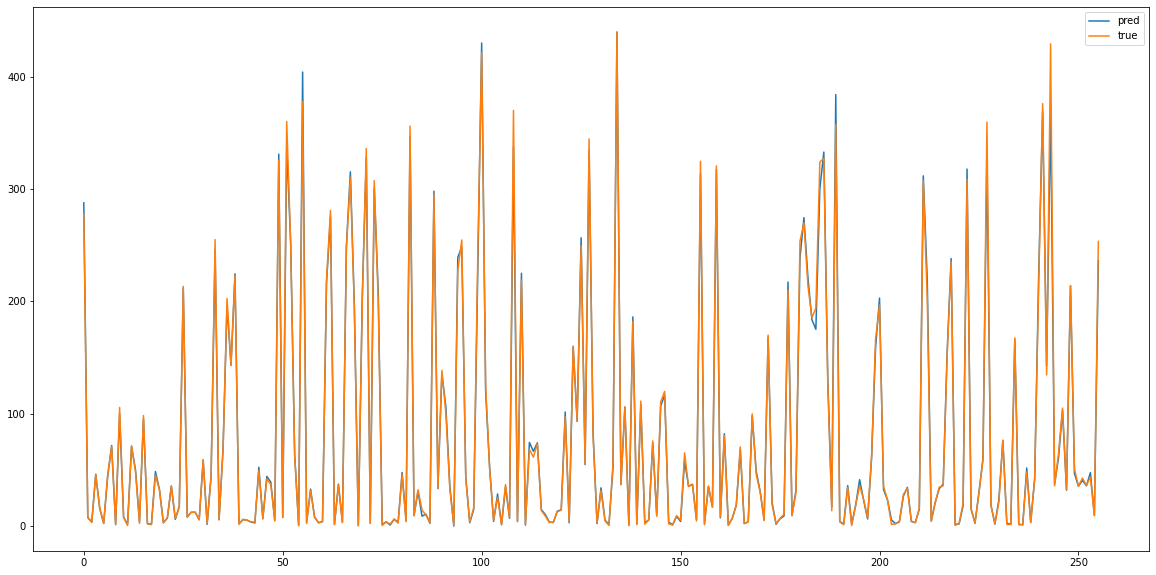

In [196]:
CATmodel = CatBoostRegressor(verbose=1, n_estimators=10000,  eval_metric='MAE', early_stopping_rounds=50)
CATmodel.fit(train_x, train_y, eval_set=[(val_x, val_y)],
                   use_best_model=True)

val_pred = CATmodel.predict(val_x)
plt.figure(figsize=(20,10))
plt.plot(np.array(val_pred),label = "pred")
plt.plot(np.array(val_y),label = "true")
plt.legend()
plt.show()

train_score = CATmodel.score(train_x, train_y) # train (learn) score

val_score = CATmodel.score(val_x, val_y) # val (test) score

# mae
# print("MAE: ",mean_absolute_error(val_y, val_pred))

In [197]:
CATresult = CATmodel.predict(test_col)

submission = pd.read_csv('./sample_submission.csv')
submission['leaf_weight'] = CATresult
submission.to_csv('./CATsubmit.csv', index=False)

In [ ]:
LGBMmodel = lgb.LGBMRegressor(objective= "regression", boosting_type='gbdt', random_state = 32, n_estimators=10000, learning_rate= 0.005,  early_stopping_rounds=50)
LGBMmodel.fit(train_x, train_y, eval_set = [(val_x, val_y)], eval_metric='l1')

val_pred = LGBMmodel.predict(val_x)
plt.figure(figsize=(20,10))
plt.plot(np.array(val_pred),label = "pred")
plt.plot(np.array(val_y),label = "true")
plt.legend()
plt.show()

In [61]:
LGBMresult = LGBMmodel.predict(test_col)

submission = pd.read_csv('./sample_submission.csv')
submission['leaf_weight'] = LGBMresult
submission.to_csv('./LGBMsubmit.csv', index=False)

In [198]:
def scale_datasets(x_train, x_test):
  """
  Standard Scale test and train data
  Z - Score normalization
  """
  standard_scaler = StandardScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled

train_scaled, test_scaled = scale_datasets(train_col, test_col)

train_x, val_x, train_y, val_y = train_test_split(train_scaled, train_target, test_size=0.2, random_state=32)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

def make_regression_ann(initializer='uniform', activation='relu', optimizer='adam', loss='mae'):

    model = Sequential()
    model.add(Dense(units=8, input_dim=7, kernel_initializer=initializer, activation=activation))
    model.add(Dense(units=6, kernel_initializer=initializer, activation=activation))
    model.add(Dense(1, kernel_initializer=initializer))
    model.compile(loss=loss, optimizer=optimizer)

    return model

param_grid = {
    'initializer': ['normal', 'uniform'],
    'activation': ['relu', 'sigmoid'],
    'optimizer': ['adam', 'rmsprop'],
    'loss': ['mse', 'mae'],
    'batch_size': [32, 64],
    'epochs': [5, 10],
}

grid_search = GridSearchCV(
    estimator=KerasRegressor(make_regression_ann, verbose=0),
    param_grid=param_grid,
    scoring='neg_mean_absolute_percentage_error',
    cv=3,
)

grid_search.fit(train_x, train_y, verbose=1)

grid_search.best_params_
# {'activation': 'sigmoid',
#  'batch_size': 32,
#  'epochs': 10,
#  'initializer': 'normal',
#  'loss': 'mae',
#  'optimizer': 'adam'}

Epoch 1/1000
32/32 [==============================] - 1s 6ms/step - loss: 79.6075 - mean_absolute_error: 79.5824 - val_loss: 80.4419 - val_mean_absolute_error: 80.4419
Epoch 2/1000
32/32 [==============================] - 0s 2ms/step - loss: 77.1919 - mean_absolute_error: 77.1678 - val_loss: 75.3603 - val_mean_absolute_error: 75.3603
Epoch 3/1000
32/32 [==============================] - 0s 3ms/step - loss: 67.8719 - mean_absolute_error: 67.8523 - val_loss: 63.4026 - val_mean_absolute_error: 63.4026
Epoch 4/1000
32/32 [==============================] - 0s 3ms/step - loss: 52.9031 - mean_absolute_error: 52.8939 - val_loss: 48.6604 - val_mean_absolute_error: 48.6604
Epoch 5/1000
32/32 [==============================] - 0s 3ms/step - loss: 39.8599 - mean_absolute_error: 39.8778 - val_loss: 33.8061 - val_mean_absolute_error: 33.8061
Epoch 6/1000
32/32 [==============================] - 0s 3ms/step - loss: 25.7897 - mean_absolute_error: 25.7803 - val_loss: 18.4254 - val_mean_absolute_error: 

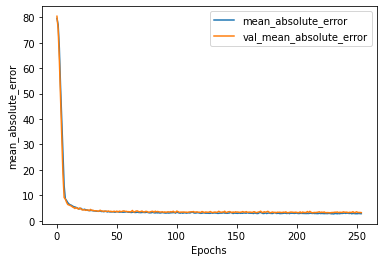

In [199]:
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(100, kernel_initializer='normal', activation='relu'),
    Dense(50, kernel_initializer='normal', activation='relu'),
    Dense(25, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model
# build the model
ANNmodel = build_model_using_sequential()

# loss function
mae = MeanAbsoluteError()
ANNmodel.compile(
    loss=mae, 
    optimizer=Adam(learning_rate=0.001), 
    metrics=[mae]
)

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=50,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# train the model
history = ANNmodel.fit(
    train_x, 
    train_y, 
    epochs=1000, 
    batch_size=32,
    validation_data=(val_x, val_y),
    callbacks=[early_stopping_monitor]
)


def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_absolute_error')

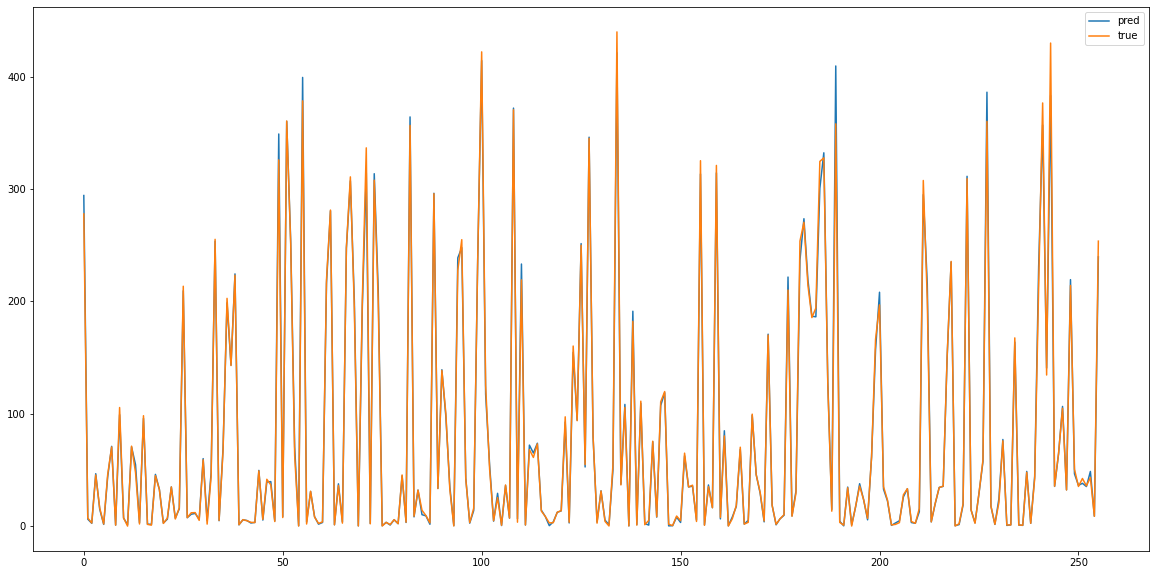

In [200]:
val_pred = ANNmodel.predict(val_x)
plt.figure(figsize=(20,10))
plt.plot(np.array(val_pred),label = "pred")
plt.plot(np.array(val_y),label = "true")
plt.legend()
plt.show()

In [201]:
ANNresult = ANNmodel.predict(test_scaled)

submission = pd.read_csv('./sample_submission.csv')
submission['leaf_weight'] = ANNresult
submission.to_csv('./ANNsubmit.csv', index=False)

In [202]:
CNN = pd.read_csv('./CNNsubmit.csv')
CAT = pd.read_csv('./CATsubmit.csv')
LGBM = pd.read_csv('./LGBMsubmit.csv')
ANN = pd.read_csv('./ANNsubmit.csv')

submission_final = pd.read_csv('./sample_submission.csv')
submission_final['leaf_weight'] = (CNN['leaf_weight'] * 0.65 + CAT['leaf_weight'] * 0.25 + ANN['leaf_weight'] * 0.1)
submission_final.to_csv('FINALsubmit.csv', index=False)